In [1]:
import glob
import os
import time
import csv

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID' 
os.environ['CUDA_VISIBLE_DEVICES']='0,1,2,3'
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from stargan2.solver_multi_GPU import Solver

import numpy as np

import matplotlib.pyplot as plt
import torch
import torchvision.utils as vutils

from torch.backends import cudnn
cudnn.benchmark = True

In [1]:
import torchvision.datasets as datasets
from itertools import groupby
import random
from torch.utils.data.sampler import WeightedRandomSampler

class ReferenceDataset(datasets.DatasetFolder):
    def __init__(
            self,
            root,
            transform = None,
            target_transform = None,
            loader = datasets.folder.default_loader,
            is_valid_file = None,
    ):
        super(ReferenceDataset, self).__init__(root, loader, 
                                          datasets.folder.IMG_EXTENSIONS if is_valid_file is None else None,
                                          transform=transform,
                                          target_transform=target_transform,
                                          is_valid_file=is_valid_file)
        
        # group samples by label
        groupped = {k: list(v) for k, v in  groupby(self.samples, lambda x: x[1])}
        
        # crate reference images
        references = []
        targets = []
        for domain, values in groupped.items():
            # unzip samples and targets
            samples, _ = zip(*values)
            # shuffle second reference images
            samples2 = random.sample(samples, len(samples))
            # repeat labels
            labels = [domain]*len(samples)
            targets+= labels
            references+= list(zip(samples, samples2, labels))
        # override samples
        self.samples = references
        # override targets to make sure that the samples have corresponding labels
        self.targets = targets
        
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (ref sample 1, ref sample 2, ref target)
        """
        ref_path1, ref_path2, ref_target = self.samples[index]

        ref1 = self.loader(ref_path1)
        ref2 = self.loader(ref_path2)
        
        if self.transform is not None:
            ref1 = self.transform(ref1)
            ref2 = self.transform(ref2)
            
        if self.target_transform is not None:
            ref_target = self.target_transform(ref_target)

        return ref1, ref2, ref_target

def make_balanced_sampler(labels):
    class_counts = np.bincount(labels)
    class_weights = 1. / class_counts
    weights = class_weights[labels]
    WeightedRandomSampler(weights, len(weights))

In [ ]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

img_size = 128
batch_size = 8
num_workers = 4

transform = transforms.Compose([
    transforms.Resize([img_size, img_size]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

ds = ImageFolder('/home/aray/stargan-v2/data/celeb_afhq/train', transform)
ds_ref = ReferenceDataset('/home/aray/stargan-v2/data/celeb_afhq/train', transform)

sampler = make_balanced_sampler(ds.targets)
loader = DataLoader(dataset=ds,
                    batch_size=batch_size,
                    sampler=sampler,
                    shuffle=True,
                    num_workers=num_workers,
                    pin_memory=True,
                    drop_last=True)

sampler_ref = make_balanced_sampler(ds_ref.targets)
loader_ref = DataLoader(dataset=ds_ref,
                        batch_size=batch_size,
                        sampler=sampler_ref,
                        shuffle=True,
                        num_workers=num_workers,
                        pin_memory=True,
                        drop_last=True)

val_dataset = ImageFolder('/home/aray/stargan-v2/data/celeb_afhq/val', transform)

In [4]:
domains, domains_mapping = val_dataset._find_classes(val_dataset.root)
n_domains = len(domains)
print('n_domains:', n_domains)
domains_mapping

n_domains: 5


{'cat': 0, 'dog': 1, 'female': 2, 'male': 3, 'wild': 4}

In [5]:
solver = Solver('StarGAN2_HumanAnimal_multyGPU', img_size, n_domains=n_domains, lambda_ds=0, pretrained_path='results/StarGAN2_HumanAnimal_multyGPU/epoch54/')

In [ ]:
solver.train(500, loader, loader_ref, val_dataset)

Epoch   1: 100.00%
        Time: 2:32:32
D       real: 0.5092859634096166
         reg: 0.08233245229208702
      fake z: 0.6105706163517034
    fake ref: 0.37408832000713943
G latent adv: 1.5225047144546613
         sty: 0.08208507950719748
         cyc: 0.21420861190526155
          ds: 0.2007848360595313
G    ref adv: 1.8476700870594285
         sty: 0.717797970280398
         cyc: 0.2210437205085928
          ds: 0.47018298706006223

Epoch   2: 100.00%
        Time: 2:32:52
D       real: 0.4895139895498406
         reg: 0.08653025828230589
      fake z: 0.6393008299127176
    fake ref: 0.3229287409006168
G latent adv: 1.4882168694603461
         sty: 0.08498248619281941
         cyc: 0.21627568146745274
          ds: 0.2014139307195785
G    ref adv: 1.9863990733551014
         sty: 1.1279332285534378
         cyc: 0.22097273072222243
          ds: 0.4784958322305937

Epoch   3: 100.00%
        Time: 2:32:57
D       real: 0.4678059305076966
         reg: 0.09191500259229113
      fa

In [7]:
solver.save_model()
solver.save_stats()

In [6]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


In [7]:
def imshow(img):
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)

In [ ]:
n = 4
rec, lat, ref = solver.save_images(val_dataset, 1, n)

In [ ]:
fig = plt.figure()
plt.box(False)
plt.xticks([], [])
plt.yticks([50, 160, 305,395], ['real', 'real ref', 'fake', 'reconstructed'])
plt.yticks(rotation=90)
plt.tick_params(length=0, labelsize=7)
imshow(vutils.make_grid(rec, padding=0, nrow=n))
# fig.tight_layout()
# rec.shape

In [ ]:
fig = plt.figure()
plt.box(False)
plt.xticks([], [])
plt.yticks([40, 185, 300, 420, 560, 690], ['input', ]+ list(domains_mapping.keys()))
plt.yticks(rotation=90)
plt.tick_params(length=0, labelsize=7)

imshow(vutils.make_grid(lat, padding=0, nrow=n))


In [ ]:
fig = plt.figure()
imshow(vutils.make_grid(ref, padding=0, nrow=n+1))
plt.axis('off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
        hspace = 0, wspace = 0)
# plt.savefig(buf, format='png', bbox_inches = 'tight', pad_inches = 0)


In [2]:
X0 = np.concatenate([np.load('X0_train_clean_48.npy'), np.load('X0_val_clean_48.npy')])
X1 = np.concatenate([np.load('X1_train_clean_48.npy'), np.load('X1_val_clean_48.npy')])

X = np.concatenate((X0, X1))
y = np.concatenate((np.zeros(len(X0)), np.ones(len(X1)))).astype(np.long)

In [ ]:
solver = Solver(X, y, 2)
solver.train(10, 16)

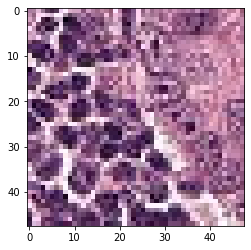

In [32]:
i = np.random.randint(len(X0))
x_ref = torch.from_numpy(X0[i][None])
imshow(x_ref)

torch.Size([1, 3, 48, 48])

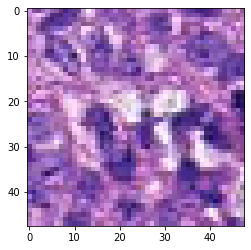

In [40]:
i = np.random.randint(len(X1))
x_real = torch.from_numpy(X1[i][None])
imshow(x_real)
x_real.shape

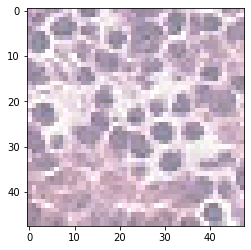

In [62]:
y_trg = torch.tensor([0]).cuda()
# s_trg = solver.style_encoder(x_ref.cuda(), y_trg)

z = torch.randn(1, solver.latent_dim).cuda()
s_trg = solver.mapping_network(z, y_trg)

x_result = ((1+solver.G(x_real.cuda(), s_trg))/2).clamp_(0, 1)
imshow(x_result.detach().cpu())

In [61]:
((x_result+1)/2).min()

tensor(0.4760, device='cuda:0', grad_fn=<MinBackward1>)